In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import (train_test_split, 
cross_val_score, permutation_test_score, RandomizedSearchCV)
from scipy.stats import uniform, randint

import re
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from deep_translator import GoogleTranslator

%load_ext autoreload
%autoreload 2

/var/folders/b1/7tbkc6wd40g89mxvkffpbcy40000gn/T/ipykernel_5623/4035090683.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


# Data preprocessing

**Fetch data on European climate protests from 2020 onwards (when it seems to start being somewhat reliably tracked)**

In [2]:
og_protests_df = pd.read_csv("./data/protests.csv")
og_protests_df.event_date = pd.to_datetime(og_protests_df.event_date)
og_protests_df.sort_values(by="event_date", inplace=True)
# Protest data from 2019 looks highly suspicious - less than 10% as many
# protests as 2020 with around 1/30th or 1/40th as many total protesters
og_protests_df = og_protests_df[og_protests_df['event_date'] >= '2020-01-01']
og_protests_df = og_protests_df[['event_date', 'tags']]

*Note: protest data was taken from the [ACLED database](https://acleddata.com/data-export-tool/) on 2024-07-17, filtering for event_type = "Protests", year = 2019 through to 2024, regions=["Europe"], keyword="climate"*

*Parliament speech data was taken from the [EU Parliament database](https://data.europarl.europa.eu/en/home); date and parameters unknown*

**Fetch data on European Parliament speech content**

In [3]:
speeches_df = pd.read_csv('./data/speeches.csv.gz', escapechar="\\", compression="gzip")
speeches_df["date"] = pd.to_datetime(speeches_df["date"])
speeches_df = speeches_df[~speeches_df.date.isna()]
speeches_df = speeches_df.sort_values('date')

In [4]:
first_protest = og_protests_df.event_date.iloc[0]
first_speech = speeches_df.date.iloc[0]
last_recorded_protest = og_protests_df.event_date.iloc[-1]
last_recorded_speech = speeches_df.date.iloc[-1]
print(f'First speech: {first_speech}')
print(f'First protest: {first_protest}')
print(f'Last recorded speech: {last_recorded_speech}')
print(f'Last recorded protest: {last_recorded_protest}')

First speech: 2002-03-19 00:00:00
First protest: 2020-01-01 00:00:00
Last recorded speech: 2024-09-29 00:00:00
Last recorded protest: 2024-07-12 00:00:00


**Ensure the dataframes cover the same date range (some protest data is available from slightly earlier, but is highly patchy)**

In [5]:
# Drop speeches outside the dates for which we have convincing protest data
speeches_df = speeches_df[(speeches_df['date'] >= '2020-01-01') & (speeches_df['date'] <= last_recorded_protest)]

# Drop protests after the last speech for which we have a complete protest record
og_protests_df = og_protests_df[og_protests_df['event_date'] <= speeches_df.date.iloc[-1]]

# speeches_df = speeches_df[~speeches_df['date'].isna()]
speeches_df = speeches_df.sort_values(by="date")
speeches_df = speeches_df[~speeches_df['date'].isna()]
speeches_df = speeches_df[~speeches_df['text'].isna()]
speeches_df.head(1)

,date,text
223,2020-01-15,\n \n2019 - 2024 \n \n \nПЪЛЕН ПРОТОКОЛ Н...


In [6]:
first_relevant_protest = og_protests_df.event_date.iloc[0]
first_relevant_speech = speeches_df.date.iloc[0]
last_relevant_protest = og_protests_df.event_date.iloc[-1]
last_relevant_speech = speeches_df.date.iloc[-1]
print(f'First relevant speech: {first_relevant_speech}')
print(f'First relevant protest: {first_relevant_protest}')
print(f'Last relevant speech: {last_relevant_speech}')
print(f'Last relevant protest: {last_relevant_protest}')

First relevant speech: 2020-01-15 00:00:00
First relevant protest: 2020-01-01 00:00:00
Last relevant speech: 2024-03-19 00:00:00
Last relevant protest: 2024-03-19 00:00:00


In [7]:
print(len(speeches_df['text'].iloc[0]))
speeches_df['text'].iloc[0][:1000]

818487


' \n \n2019  - 2024  \n \n \nПЪЛЕН  ПРОТОКОЛ  НА РАЗИСКВАНИЯТА    DEBAŠU  STENOGRAMMA  \nACTA  LITERAL  DE LOS  DEBATES    POSĖDŽIO  STENOGRAMA  \nDOSLOVNÝ  ZÁZNAM  ZE ZASEDÁNÍ    AZ ÜLÉSEK  SZÓ  SZERINTI  JEGYZŐKÖNYVE  \nFULDSTÆNDIGT  FORHANDLINGSREFERAT    RAPPORTI  VERBATIM  TAD-DIBATTITI  \nAUSFÜHRLICHE  SITZUNGSBERICHTE    VOLLEDIG  VERSLAG  VAN  DE VERGADERINGEN  \nISTUNGI  STENOGRAMM    PEŁNE  SPRAWOZDANIE  Z OBRAD  \nΠΛΗΡΗ  ΠΡΑΚΤΙΚΑ  ΤΩΝ  ΣΥΖΗΤΗΣΕΩΝ    RELATO  INTEGRAL  DOS  DEBATES  \nVERBATIM  REPORT  OF PROCEEDINGS    STENOGRAMA  DEZBATERILOR  \nCOMPTE  RENDU  IN EXTENSO  DES  DÉBATS    DOSLOVNÝ  ZÁPIS  Z ROZPRÁV  \nTUARASCÁIL  FOCAL  AR FHOCAL  NA N-IMEACHTAÍ    DOBESEDNI  ZAPISI  RAZPRAV  \nDOSLOVNO  IZVJEŠĆE    SANATARKAT  ISTUNTOSELOSTUKSET  \nRESOCONTO  INTEGRALE  DELLE  DISCUSSIONI    FULLSTÄNDIGT  FÖRHANDLINGSREFERAT  \n \n \nСряда  - Miércoles  - Středa  - Onsdag  - Mittwoch  - Kolmapäev  - Τετάρτη  - Wednesday  \nMercredi  - Dé Céadaoin  - Srijeda  - Mercoledì  - Tr

**Remove prepended metadata from speech transcripts TODO: refine this regex (though it seems to be working surprisingly well for an MVP)**

In [8]:
def preprocess(text):
  pattern = re.compile(r'\.+.*\.+') # delete first section with '...'
  text = pattern.sub(r'', text)
  pattern = re.compile(r"\n") # delete new line markers
  text = pattern.sub(r'', text)
  text = re.sub(r'\s+', ' ', text) # delete additional whitespace between words
  text = text.lower()
  return text

In [9]:
speeches_df["clean_text"] = speeches_df["text"].progress_apply(preprocess)

  0%|          | 0/226 [00:00<?, ?it/s]

**Combine transcript of multiple speeches on a single day, so we have at most one transcript per day**

In [10]:
# Fill missing values in the "text" column with empty strings
speeches_df["clean_text"] = speeches_df["clean_text"].fillna("")

# Group by day and aggregate the text
speeches_df = speeches_df.groupby(speeches_df["date"]).agg({"clean_text": " ".join})

In [11]:
speeches_df['speech_length'] = speeches_df["clean_text"].str.len()

In [12]:
print(len(speeches_df['clean_text'].iloc[0]))
speeches_df['clean_text'].iloc[0][:1000]

646375


' 2019 - 2024 пълен протокол на разискванията debašu stenogramma acta literal de los debates posėdžio stenograma doslovný záznam ze zasedání az ülések szó szerinti jegyzőkönyve fuldstændigt forhandlingsreferat rapporti verbatim tad-dibattiti ausführliche sitzungsberichte volledig verslag van de vergaderingen istungi stenogramm pełne sprawozdanie z obrad πληρη πρακτικα των συζητησεων relato integral dos debates verbatim report of proceedings stenograma dezbaterilor compte rendu in extenso des débats doslovný zápis z rozpráv tuarascáil focal ar fhocal na n-imeachtaí dobesedni zapisi razprav doslovno izvješće sanatarkat istuntoselostukset resoconto integrale delle discussioni fullständigt förhandlingsreferat сряда - miércoles - středa - onsdag - mittwoch - kolmapäev - τετάρτη - wednesday mercredi - dé céadaoin - srijeda - mercoledì - trešdiena - trečiadienis - szerda l-erbgħa - woensdag - środa - quarta-feira - miercuri - streda - sreda - keskiviikko - onsdag 152020 единство в многообрази

**Get a translation of the phrase 'climate change' for every European language**

In [13]:
# translate keywords to eu-languages
keywords = "climate change"
eu_lang = ['bg','cs','da','de','el','en','es','et','fi','fr','ga','hr','hu','it','lt','lv','mt','nl','pl','pt','ro','sk','sl','sv']
keywords_translated = []
for i in eu_lang:
  translated = GoogleTranslator(source='auto', target=i).translate(text=keywords)
  keywords_translated.append(translated)
keywords_eu_lang = "|".join(keywords_translated).lower()

**Find out what proportion of words in the transcript for each day with at least one speech are (a translation of) the phrase 'climate change' ("Down with climate change!" would register as 0.25)**

In [14]:
speeches_df['climate_mentions_percent'] = (speeches_df["clean_text"].str.count(keywords_eu_lang) / speeches_df["clean_text"].str.split().str.len())*100
speeches_df.drop('clean_text', axis=1, inplace=True)
speeches_df.head()

,speech_length,climate_mentions_percent
date,,
2020-01-15,646375,0.013057
2020-01-29,448030,0.012614
2020-02-12,716390,0.018191
2020-03-19,10207308,0.020888
2020-05-13,230860,0.008285


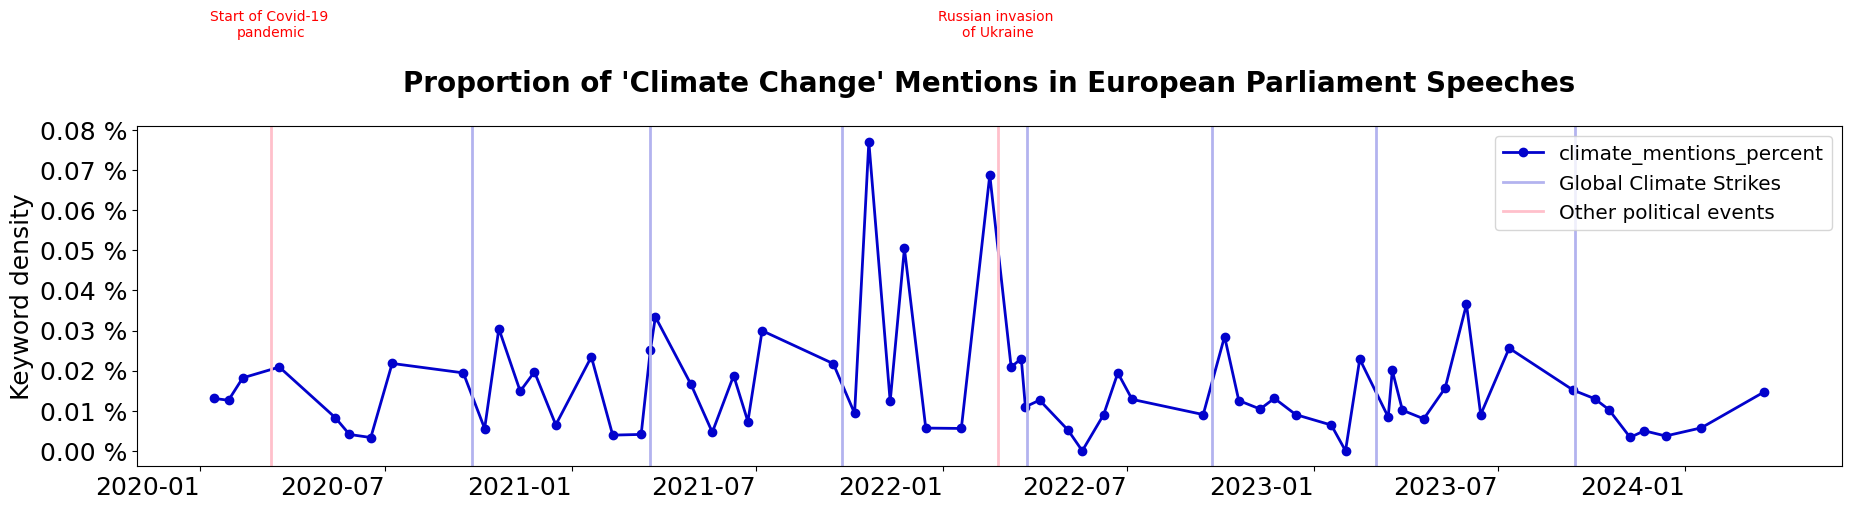

In [15]:
fig, ax = plt.subplots(figsize=(22, 5))
speeches_df['climate_mentions_percent'].plot(ax=ax, marker='o', linestyle='-', linewidth=2, color="#0202cc", fontsize=18)

ax.set_title("Proportion of 'Climate Change' Mentions in European Parliament Speeches", fontsize=20, fontweight = "bold", pad=25)
ax.set_ylabel("Keyword density",fontsize=18)
ax.set_xlabel("")

def format_func(value, tick_number):
  return '{:.2f} %'.format(value)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_func))

gcs_dates = ["2020-09-25", "2021-03-19", "2021-09-24", "2022-03-25", "2022-09-23", "2023-03-03", "2023-09-15"]
for i in gcs_dates:
  plt.axvline(x = i, color = '#b3b3ef', label = 'Global Climate Strikes', linewidth=2)

fig.autofmt_xdate()

plt.axvline(x = "2020-03-11", color = 'pink', label = 'Other political events', linewidth=2)
plt.axvline(x = "2022-02-24", color = 'pink', label = 'Other political events', linewidth=2)
ax.text("2020-03-11", 0.11, "Start of Covid-19 \npandemic", rotation=0, verticalalignment='top', horizontalalignment='center', color="red")
ax.text("2022-02-24", 0.11, "Russian invasion \nof Ukraine", rotation=0, verticalalignment='top', horizontalalignment='center', color="red")

# Remove legend
# ax.legend().remove()
# Get legend handles and labels
handles, labels = ax.get_legend_handles_labels()
legend_dict = {label: handle for handle, label in zip(handles, labels)}
legend_dict.pop('speech_count', None)

# Create legend for each color
plt.legend(legend_dict.values(), legend_dict.keys(), loc='upper right', fontsize="x-large")


# Rotate x-axis tick labels
plt.xticks(rotation=0)

plt.show()

**Convert natural language statements of crowd size at protests into integers. For now, we leave 'unknown' as NAN, and flag them for later processing since there are various things we might decide to do here.**

In [16]:
def infer_crowd_size(tag):
  """Convert the text strings giving estimated protester counts (sometimes as a
  range) into an integer (in the middle of the range)"""

  # Start with the numerous special cases
  if any (s in tag for s in ("several", "multiple", "a few", "some", "a group",
    "a small group", "small group", "a couple", "half dozen", "half-dozen",
    "half a dozen", "a handful", "handful", "small")
  ):
    return 5

  estimates = {
    ("hundreds", "hundred"): 500,
    ("between hundreds and 2000",): 2750,
    ("thousands", "thousand"): 5000,
    ("tens of thousands",): 50_000,
    ("hundreds of thousands",): 500_000,
    ("between dozens and 250",): (50+250)//2,
    ("one to three",): 2,
    ("two dozens",): 24
  }

  for text, estimate in estimates.items():
    if any (s in tag for s in text):
      return estimate

  if any (s in tag for s in ("dozens", "tens", "tenfold", "scores", "big group",
    "large group", "numerous", "many", "large number", "numerous small groups",
    "large", "multitude")):
    return 50

  # Regex to capture Arabic numbers that may or may not include commas:
  number_pattern = '\d{1,3}(?:,?\d*)*'
  numbers = re.findall(number_pattern, tag)
  # Remove commas from numbers and then convert them to integers
  numbers = [int(num.replace(',', '')) for num in numbers]

  # If we have two or more numbers, assume it's a range, and take their mean
  mean = np.mean(numbers)

  if tag.endswith("dozen") and any(numbers):
    return mean * 12
  if tag.endswith("dozen"):
    return 12

  # Don't replace NaNs yet
  if np.isnan(mean):
    return np.nan
  return int(round(mean))

og_protests_df['protesters_estimate'] = og_protests_df['tags'].apply(infer_crowd_size)
og_protests_df['size_is_unknown'] = og_protests_df['protesters_estimate'].isna().astype(int)

/Users/sashacooper/.pyenv/versions/3.10.6/envs/climate/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sashacooper/.pyenv/versions/3.10.6/envs/climate/lib/python3.10/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


**Frustratingly, we're missing data on the size of protest for the majority of protests**

In [17]:
len(og_protests_df), sum(og_protests_df['size_is_unknown'])

(9036, 5694)

# Model 1: Naive regression, grouping protests by a large regular interval

Since we don't have a target value unless there's at least one speech, we could group all our data by regular intervals - but those intervals have to be large enough to reliably contain a speech throughout our data (which turns out to be every 70 days).


**Find the max interval between speeches**

In [18]:
dates = pd.Series(speeches_df.index)

intervals = [dates.iloc[i] - dates.iloc[i - 1] for i in range(len(speeches_df)) if i > 0] 
max_interval = max(intervals)
max_interval

Timedelta('70 days 00:00:00')

**Group each protest and each speech into some number of max_intervals (i.e. 70-day periods) from our start time**

In [19]:
def count_intervals_from_start(date):
    start_date = og_protests_df['event_date'].min()
    offset = pd.offsets.Day(max_interval.days)
    period = start_date.to_period(freq=offset)
    intervals = (date - start_date) // max_interval
    return period + intervals + 1

# Create a new column with the periods
speeches_df['grouping_period'] = speeches_df.index.map(count_intervals_from_start)

# Group by the period
y_regular = speeches_df.groupby('grouping_period')['climate_mentions_percent'].mean()
y_regular.head(3)

grouping_period
2020-03-11    0.014621
2020-05-20    0.014586
2020-07-29    0.009729
Freq: 70D, Name: climate_mentions_percent, dtype: float64

In [20]:
# Group the protests by the same interval as above
og_protests_df['grouping_period'] = og_protests_df['event_date'].map(count_intervals_from_start)

num_protests = og_protests_df.groupby('grouping_period').size()

regularised_protests_df = og_protests_df.groupby('grouping_period').agg({
    'protesters_estimate': 'sum',
    'size_is_unknown': 'sum'
}).assign(num_protests=og_protests_df.groupby('grouping_period').size())

regularised_protests_df.head(3)

,protesters_estimate,size_is_unknown,num_protests
grouping_period,,,
2020-03-11,122288.0,263,407
2020-05-20,2125.0,96,142
2020-07-29,12556.0,185,278


**For our basic model, we treat each 70-day period as unrelated, with protests having no persistent effects beyond the subsequent speech. We also assume the mean number of protesters for those with missing values**

In [21]:
class ProtestSizeImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['protesters_estimate'] = X['protesters_estimate'] + X['size_is_unknown'] * og_protests_df['protesters_estimate'].mean()

        # Make this method agnostic as to whether the features include number of protests, for easy iteration later
        columns_to_return = ['protesters_estimate']
        if 'num_protests' in X.columns:
            columns_to_return.append('num_protests')
            
        return X[columns_to_return]


**There's already strong and robust correlations between [number of *protests* & climate mentions] and between [number of protest*ers* & climate mentions]**

In [22]:
transformer = Pipeline([
    ('protest_size_imputer', ProtestSizeImputer()),
    ('scaler', RobustScaler()), # TODO maybe standard scaler is better since this is relatively smooth


correlation_df = ProtestSizeImputer().transform(regularised_protests_df)

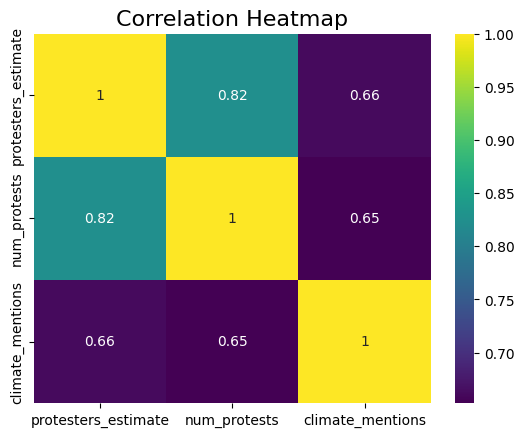

In [27]:
correlation_df['climate_mentions'] = y_regular
sns.heatmap(regularised_protests_df[['protesters_estimate', 'num_protests', 'climate_mentions']].corr(), annot=True, cmap='viridis')
plt.title("Correlation Heatmap", fontsize=16);

In [28]:
from scipy import stats

protests_corr, protests_p_val = stats.pearsonr(correlation_df['num_protests'], correlation_df['climate_mentions'])[0:2]
protesters_corr, protesters_p_val = stats.pearsonr(correlation_df['protesters_estimate'], correlation_df['climate_mentions'])[0:2]
protesters_ci_low, protesters_ci_high = stats.pearsonr(correlation_df['protesters_estimate'], correlation_df['climate_mentions']).confidence_interval(0.9)
print(f"p-value for [protests/climate mentions] correlation: {protests_p_val}")
print(f"p-value for [protesters/climate mentions] correlation: {protesters_p_val}")
print(f"90% confidence interval for protesters correlation: ({protesters_ci_low, protesters_ci_high})")
protests_corr, protesters_corr

p-value for [protests/climate mentions] correlation: 0.0009999459368019584
p-value for [protesters/climate mentions] correlation: 0.0002701769943015717
90% confidence interval for protesters correlation: ((np.float64(0.45744575216332634), np.float64(0.8479431225194269)))


(np.float64(0.6523804128652052), np.float64(0.702100766438573))

**The following step plot compares the number of protesters and climate mentions over consecutive 70-day periods.**

In [ ]:
fig, ax = plt.subplots(figsize=(22, 8))
protester_color = 'green'
climate_mentions_color = "purple"

# Extend the time series by one period
last_period = y_regular.index[-1]
next_period = last_period + 1
extended_index = y_regular.index.append(pd.PeriodIndex([next_period]))

# Create extended series for both datasets
extended_protesters = pd.Series(correlation_df['protesters_estimate'].values.tolist() + [correlation_df['protesters_estimate'].iloc[-1]], index=extended_index)
extended_climate = pd.Series(y_regular.values.tolist() + [y_regular.iloc[-1]], index=extended_index)

# Convert PeriodIndex to DatetimeIndex for plotting
datetime_index = extended_index.to_timestamp(how='start')

# Plot protest_stock
ax.step(datetime_index, extended_protesters, where='post', label='Protesters scaled', color=protester_color, linewidth=2)

# Set primary y-axis label
ax.set_ylabel("Protesters in period", color=protester_color)
ax.tick_params(axis='y', labelcolor=protester_color)

# Create a secondary y-axis
ax2 = ax.twinx()

# Plot climate_mentions_percent on the secondary y-axis
ax2.step(datetime_index, extended_climate, where='post', label='Climate Mentions Percent', color=climate_mentions_color, linewidth=2)

# Set secondary y-axis label and color
ax2.set_ylabel("Climate Mentions Percent", color=climate_mentions_color)
ax2.tick_params(axis='y', labelcolor=climate_mentions_color)

# Set the limits for the secondary y-axis
max_climate_mentions = y_regular.max()
ax2.set_ylim(0, max_climate_mentions * 1.1)  # Set max to 110% of the actual max value

# Set x-axis label
ax.set_xlabel("Date")

# Set title
plt.title(f"Step plot: Number of protesters vs Climate Mentions over {max_interval.days} day periods", fontsize=20, fontweight="bold", pad=25)

# Format x-axis labels to show date ranges
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, ha='right')

# Add legend
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Adjust layout to prevent clipping of labels
fig.tight_layout()

plt.show()

**Since we're not looking at any time-sensitive notion of data, we can use a regular train/test split for our base model...**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(regularised_protests_df, y_regular, test_size=0.2)

In [ ]:
pd.concat([regularised_protests_df.tail(4), y_regular.tail(4)], axis=1)

In [ ]:
split_date = regularised_protests_df.index[-int(len(regularised_protests_df) * 0.2)]

X_train = regularised_protests_df.loc[:split_date]
X_test = regularised_protests_df.loc[split_date:]
y_train = y_regular.loc[:split_date]
y_test = y_regular.loc[split_date:]

In [ ]:
pd.concat([X_test, y_test], axis=1)

**... but this combined with such large groupings leaves us with very little data :(**

In [ ]:
X_train.shape

**We don't have any hyperparameters in the base model, so can jump straight into scoring it**

In [ ]:
protester_pipeline = Pipeline([
    ('protest_size_imputer', ProtestSizeImputer()),
    ('scaler', RobustScaler()), # TODO maybe standard scaler is better since this is relatively smooth
    ('linear_regression', LinearRegression())
])

protest_and_protester_model_score = cross_val_score(protester_pipeline, regularised_protests_df[['protesters_estimate', 'size_is_unknown', 'num_protests']], y_regular).mean()
protester_model_score = cross_val_score(protester_pipeline, regularised_protests_df[['protesters_estimate', 'size_is_unknown']], y_regular).mean()

protest_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('linear_regression', LinearRegression())
])
protest_model_score = cross_val_score(protest_pipeline, regularised_protests_df[['num_protests']], y_regular).mean()

print(f"Score using both protest and protester data: {protest_and_protester_model_score}")
print(f"Score using protest data only: {protest_model_score}")
print(f"Score using protester data only: {protester_model_score}")


In [ ]:
y_test

In [ ]:
permutation_test_score(LinearRegression(), regularised_protests_df[['protesters_estimate']], y_regular, n_permutations=100)

# Adstock model

In [ ]:
decay_param = ri_random_search.best_params_['regularised_protest_stock_calculator__decay_param']
initial_stock = ri_random_search.best_params_['regularised_protest_stock_calculator__initial_stock']

ri_data_transform = Pipeline([
  ('regularised_protest_stock_calculator', RegularisedProtestStockCalculator(decay_param=decay_param, initial_stock=initial_stock)),
])

ri_data_scaler = Pipeline([
  ('protest_size_imputer', ProtestSizeImputer(assumed_size=assumed_size)),
  ('regularised_protest_stock_calculator', RegularisedProtestStockCalculator(decay_param=decay_param, initial_stock=initial_stock)),
  ('scaler', RobustScaler())
])

ri_adstock_df = ri_data_transform.fit_transform(regularised_protests_df)
ri_adstock_arr = ri_data_scaler.fit_transform(regularised_protests_df)
decay_param, initial_stock

In [ ]:
class RegularisedProtestStockCalculator(BaseEstimator, TransformerMixin):
    def __init__(self, decay_param=0.99, initial_stock=600_000):
        self.decay_param = decay_param
        self.initial_stock = initial_stock

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        protester_stock = np.zeros(len(X))
        protester_stock[0] = self.initial_stock + X['protesters_estimate'].iloc[0]
        for t in range(1, len(X)):
            protester_stock[t] = X['protesters_estimate'].iloc[t] + self.decay_param * protester_stock[t-1]

        # Then repeat above, but counting protests rather than protesters
        protester_stock = np.zeros(len(X))
        protester_stock[0] = self.initial_stock + X['protesters_estimate'].iloc[0]
        for t in range(1, len(X)):
            protester_stock[t] = X['protesters_estimate'].iloc[t] + self.decay_param * protester_stock[t-1]
        return pd.DataFrame({'protester_stock': protester_stock.flatten()}, index=X.index)



# Create the full pipeline
regularised_interval_pipeline = Pipeline([
    ('protest_size_imputer', ProtestSizeImputer()),
    ('regularised_protest_stock_calculator', RegularisedProtestStockCalculator()),
    ('scaler', RobustScaler()), # TODO maybe standard scaler is better since this is relatively smooth
    ('linear_regression', LinearRegression())
])

# Set up RandomizedSearchCV
ri_param_distributions = {
    'regularised_protest_stock_calculator__decay_param': uniform(0, 0.2),
    'regularised_protest_stock_calculator__initial_stock': randint(0, 80_000),
    'protest_size_imputer__assumed_size': randint(0, 2000),
}

ri_random_search = RandomizedSearchCV(
    regularised_interval_pipeline,
    ri_param_distributions,
    cv=5,
    scoring='neg_mean_squared_error',
    n_iter=300,
    # random_state=42# adjust as needed
)

# Fit the random search
ri_random_search.fit(regularised_protests_df, y_regular)

# Get best parameters
print(ri_random_search.best_params_)

# Get the best estimator
best_ri_model = ri_random_search.best_estimator_

In [ ]:
class ProtestSizeImputer(BaseEstimator, TransformerMixin):
    def __init__(self, assumed_size=3000):
        self.assumed_size = 0

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['protesters_estimate'] = X['protesters_estimate'] + X['size_is_unknown'] * self.assumed_size
        return X

class RegularisedProtestStockCalculator(BaseEstimator, TransformerMixin):
    def __init__(self, decay_param=0.99, initial_stock=600_000):
        self.decay_param = decay_param
        self.initial_stock = initial_stock

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        protester_stock = np.zeros(len(X))
        protester_stock[0] = self.initial_stock + X['protesters_estimate'].iloc[0]
        for t in range(1, len(X)):
            protester_stock[t] = X['protesters_estimate'].iloc[t] + self.decay_param * protester_stock[t-1]
        return pd.DataFrame({'protester_stock': protester_stock.flatten()}, index=X.index)



# Create the full pipeline
regularised_interval_pipeline = Pipeline([
    ('protest_size_imputer', ProtestSizeImputer()),
    ('regularised_protest_stock_calculator', RegularisedProtestStockCalculator()),
    ('scaler', RobustScaler()), # TODO maybe standard scaler is better since this is relatively smooth
    ('linear_regression', LinearRegression())
])

# Set up RandomizedSearchCV
ri_param_distributions = {
    'regularised_protest_stock_calculator__decay_param': uniform(0, 0.2),
    'regularised_protest_stock_calculator__initial_stock': randint(0, 80_000),
    'protest_size_imputer__assumed_size': randint(0, 1),
}

ri_random_search = RandomizedSearchCV(
    regularised_interval_pipeline,
    ri_param_distributions,
    cv=5,
    scoring='neg_mean_squared_error',
    n_iter=300,
    # random_state=42# adjust as needed
)

# Fit the random search
ri_random_search.fit(regularised_protests_df, y_regular)

# Get best parameters
print(ri_random_search.best_params_)

# Get the best estimator
best_ri_model = ri_random_search.best_estimator_

In [ ]:
protests_df['protester_stock'] = adstock_df['protest_stock']
protests_df['climate_mentions_percent'] = y
protests_df.corr()

# Original model

**Sum the number of protests and (known) protesters between each date on which there was a speech**

In [ ]:
def get_next_speech_date(date):
    idx = speeches_df.index.searchsorted(date)
    return speeches_df.index[idx]

og_protests_df['next_speech_date'] = og_protests_df['event_date'].apply(get_next_speech_date)

In [ ]:
# Group the protests by when the subsequent speech was, but retain info of how many of them there were,
# and of those, how many were unknown, since we need to retrospectively impute
# these later

num_protests = og_protests_df.groupby('next_speech_date').size()

protests_df = og_protests_df.groupby('next_speech_date').agg({
    'protesters_estimate': 'sum',
    'size_is_unknown': 'sum'
}).assign(num_protests=og_protests_df.groupby('next_speech_date').size())

In [ ]:
protests_df.index = pd.to_datetime(protests_df.index)

# Some speeches don't have any record of protests between them. For now,
# we'll take that at face value and assume that means there were no protests
protests_df = protests_df.reindex(speeches_df.index, fill_value=0)

# Calculate the difference in days using a list comprehension
days_diff = [0] + [(protests_df.index[i] - protests_df.index[i-1]).days
                   for i in range(1, len(protests_df))]

# Add the new column to the dataframe
protests_df['days_since_last'] = days_diff

# Fill the first row's value with number of days between start of protest data
# and the first speech in our date range
protests_df.loc[protests_df.index[0], 'days_since_last'] = (protests_df.index[0] - first_protest).days

In [ ]:
class ProtestSizeImputer(BaseEstimator, TransformerMixin):
    def __init__(self, assumed_size=3000):
        self.assumed_size = 0

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['protesters_estimate'] = X['protesters_estimate'] + X['size_is_unknown'] * self.assumed_size
        return X

class ProtestTimeAccounter(BaseEstimator, TransformerMixin):
    """Averages the number of protesters over number of days between speeches"""

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['protesters_per_day_estimate'] = X['protesters_estimate'] / X['days_since_last']
        return X

class ProtestStockCalculator(BaseEstimator, TransformerMixin):
    def __init__(self, decay_param=0.99, initial_stock=600_000):
        self.decay_param = decay_param
        self.initial_stock = initial_stock

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        protest_stock = np.zeros(len(X))
        protest_stock[0] = self.initial_stock + X['protesters_per_day_estimate'].iloc[0]
        for t in range(1, len(X)):
            # Treating speeches themselves as the unit of time
            # protest_stock[t] = X['protesters_per_day_estimate'].iloc[t] + self.decay_param * protest_stock[t-1]

            # Partially accounting for time between speeches
            protest_stock[t] = X['protesters_per_day_estimate'].iloc[t] + self.decay_param ** (X['days_since_last'].iloc[t]) * protest_stock[t-1]
        return pd.DataFrame({'protest_stock': protest_stock.flatten()}, index=X.index)
        # X['protest_stock'] = protest_stock
        # return X['protest_stock']



# Create the full pipeline
pipeline = Pipeline([
    ('protest_size_imputer', ProtestSizeImputer()),
    ('protest_time_accounter', ProtestTimeAccounter()),
    ('protest_stock_calculator', ProtestStockCalculator()),
    ('scaler', RobustScaler()), # TODO maybe standard scaler is better since this is relatively smooth
    ('linear_regression', LinearRegression())
])

# Set up RandomizedSearchCV
param_distributions = {
    'protest_stock_calculator__decay_param': uniform(0.4, 0.6),
    'protest_stock_calculator__initial_stock': randint(0, 50_000),
    'protest_size_imputer__assumed_size': randint(0, 5000),
}

# Assuming you have your data in protests_df and y
y = speeches_df['climate_mentions_percent']

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions,
    cv=5,
    scoring='neg_mean_squared_error',
    n_iter=100,
    random_state=42# adjust as needed
)

# Fit the random search
random_search.fit(protests_df, y)

# Get best parameters
print(random_search.best_params_)

# Get the best estimator
best_model = random_search.best_estimator_

# You can now use best_model to make predictions
# predictions = best_model.predict(new_data)

# Time-insensitive model
# {'protest_size_imputer__assumed_size': 527, 'protest_stock_calculator__decay_param': 0.9229701077973101, 'protest_stock_calculator__initial_stock': 211}
# {'protest_size_imputer__assumed_size': 4924, 'protest_stock_calculator__decay_param': 0.922730372125585, 'protest_stock_calculator__initial_stock': 1337}


# Time-sensitive model

In [ ]:
assumed_size = random_search.best_params_['protest_size_imputer__assumed_size']
decay_param = random_search.best_params_['protest_stock_calculator__decay_param']
initial_stock = random_search.best_params_['protest_stock_calculator__initial_stock']

# assumed_size = 860
# decay_param = 0.55
# initial_stock = 25_000

data_transform = Pipeline([
  ('protest_size_imputer', ProtestSizeImputer(assumed_size=assumed_size)),
  ('protest_time_accounter', ProtestTimeAccounter()),
  ('protest_stock_calculator', ProtestStockCalculator(decay_param=decay_param, initial_stock=initial_stock)),
])

data_scaler = Pipeline([
  ('protest_size_imputer', ProtestSizeImputer(assumed_size=assumed_size)),
  ('protest_time_accounter', ProtestTimeAccounter()),
  ('protest_stock_calculator', ProtestStockCalculator(decay_param=decay_param, initial_stock=initial_stock)),
  ('scaler', RobustScaler())
])

adstock_df = data_transform.fit_transform(protests_df)
adstock_arr = data_scaler.fit_transform(protests_df)

**The following step graph shows how protester count corresponds to climate mentions over 70-day periods**

In [ ]:
fig, ax1 = plt.subplots(figsize=(22, 5))

protester_color = 'green'
# Plot protest_stock on the primary y-axis
ax1.plot(speeches_df.index, adstock_df['protest_stock'], marker='o', linestyle='-', linewidth=2, color=protester_color)
ax1.set_xlabel("Date")
ax1.set_ylabel("Protester Stock", color=protester_color)
ax1.tick_params(axis='y', labelcolor=protester_color)

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot climate_mentions_percent on the secondary y-axis
climate_mentions_color = "purple"
ax2.plot(speeches_df.index, y, marker='o', linestyle='-', linewidth=2, color=climate_mentions_color)
ax2.set_ylabel("Climate Mentions Percent", color=climate_mentions_color)
ax2.tick_params(axis='y', labelcolor=climate_mentions_color)

# Set title
plt.title("'Protester stock' vs Climate Mentions", fontsize=20, fontweight="bold", pad=25)

# Adjust layout to prevent clipping of labels
fig.tight_layout()

plt.show()